In [1]:
root="../../.."

---
# Raw Feature to raw score

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
immune = pd.read_csv("%s/data/immuno/immune_percentage.csv"%(root),index_col=0).transpose()
kegg = pd.read_csv("%s/data/metagenomics/KEGG_downsampled_90percent_maaslined.csv"%(root), index_col=0).transpose()
specie = pd.read_csv("%s/data/metagenomics/Specie_abundance_filtered_90percent_maaslined.csv"%(root),index_col=0).transpose()
metabolome = pd.read_csv("%s/data/metabolomics/Metabolomics_maaslined_norun.csv"%(root), index_col=0).transpose()

In [4]:
data_dict = dict(zip(['immune','kegg','specie','metabolome'],[immune,kegg,specie,metabolome]))
model_name_dict=dict(zip(['immune','kegg','specie','metabolome'],['Immune','KEGG','Species','Metabolome']))

---
# Plot for each Omics

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import load

In [6]:
result_dict = load("%s/codes/AI/output/shap/Score_Specific_Biomarkers.joblib"%(root))
imp_feature_list = {}
imp_feature_name_list = {}

---
# Grab the data

In [7]:
specie_list = result_dict['specie']
specie_imp_feature = ['Faecalibacterium_prausnitzii',
                    'Parasutterella_excrementihominis',
                    'Clostridium_sp_AM49_4BH',
                    'Flavonifractor_plautii',
                    'Alistipes_communis']
specie_imp_feature_name = ['Faecalibacterium\nPrausnitzii',
                    'P.Excrementihominis',
                    'Clostridium.sp',
                    'F.plautii',
                    'A.Communis']
imp_feature_list['specie'] = specie_imp_feature
imp_feature_name_list['specie'] = specie_imp_feature_name

In [8]:
immune_list = result_dict['immune']
immune_imp_feature = ['% CD4+ RO+ CCR6- d6', '% CD4+ RO+ CCR6+ CD161+ IL-17+ INFg+ d6',
                      '% CD4+ RO+ CD161- IL-17- INFg+ d6','% CD4+ IL-17+ IL-22+ d6',
                      '% Dcs CD1c+ d0', 'total % CD8+ d0']
immune_imp_feature_name = ['CD4 Memory','CD4 M INFg+','Th17 INFg+','Th17 IL22+',
                           'DC CD1c+','CD8']
imp_feature_list['immune'] = immune_imp_feature
imp_feature_name_list['immune'] = immune_imp_feature_name

In [9]:
metabolome_list = result_dict['metabolome']
metabolome_imp_feature = ['cerotoylcarnitine (C26)*', 
                          '11beta-hydroxyandrosterone glucuronide',
                          'glutamine',
                          'theobromine',
                          '2-hydroxybutyrate/2-hydroxyisobutyrate']
metabolome_imp_feature_name = ['CerotoylCarnitine', 
                          'Glucuronide',
                          'Glutamine',
                          'Theobromine',
                          'HydroxyButyrate']     
imp_feature_list['metabolome'] = metabolome_imp_feature
imp_feature_name_list['metabolome'] = metabolome_imp_feature_name

In [10]:
kegg_list = result_dict['kegg']
kegg_imp_feature = ['K01420','K03101','K03803','K01198','K22901','K01972']
kegg_imp_feature_name = ['K01420|fnr','K03101|lspA','K03803|rseC','K01198|xynB','K22901|trm4','K01972|E6.5.1.2']
imp_feature_list['kegg'] = kegg_imp_feature
imp_feature_name_list['kegg'] = kegg_imp_feature_name

---
# Supplimental Plot: plot each example feature in the circlized plot for every omics, their correlation with the actual score, colored by SHAP value

In [11]:
score_name_list = [i.columns[0] for i in result_dict['immune']]
score_name_list = [i.split(".")[1].replace("_", " ").title() for i in score_name_list]
score_name_list = [i.replace("Role Limitations Due To ","") for i in score_name_list]

In [12]:
def scatter_score_feature_shap(table, ax, feature_name=None, score_name=None, col_palette='coolwarm', order=2):
    sns.scatterplot(data=table, y='score', x='feature', size=0.5, hue='color', palette=col_palette, ax=ax)
    sns.regplot(data=table, y='score', x='feature', scatter=False, color='grey', order=order, ax=ax)
    ax.set_title(feature_name,fontsize=5, fontweight='bold')
    ax.set_ylabel(score_name,fontsize=5, fontweight='bold')
    ax.set_xlabel(None)
    ax.legend().remove()
    return ax

In [13]:
def scatter_omics(model_name, rownum = 5, colnum = 8):
    result = result_dict[model_name]
    data = data_dict[model_name].loc[result[0].index,:]
    feature_list = imp_feature_list[model_name]
    feature_name_list = imp_feature_name_list[model_name]
    rownum, colnum = rownum, colnum
    sns.set(style='ticks', font_scale=0.3, font='sans-serif')
    fig, axes = plt.subplots(rownum,colnum, figsize=(colnum*1.2, rownum*1.2)) 
    ax_list = [axes[i, j] for i in range(rownum) for j in range(colnum)]

    plot_counts = 0
    for score_index in range(12):
        result_i = result[score_index]
        score_name = score_name_list[score_index]
        for i, feature_i in enumerate(feature_list):
            if feature_i in result_i.columns:
                table = pd.concat([data.loc[:, feature_i], 
                               result_i.iloc[:,0],
                               result_i.loc[:,feature_i]], axis=1)
                table.columns = ['feature', 'score', 'color']
                ax = ax_list[plot_counts]
                ax = scatter_score_feature_shap(table, ax, feature_name_list[i], score_name)
                plot_counts +=1
            
    while plot_counts < rownum * colnum: 
        ax_list[plot_counts].axis('off')
        plot_counts += 1
        
    fig.text(-0.02, 0.5, model_name_dict[model_name], 
             va='center', rotation='vertical', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.4)
    plt.savefig("%s/output/AI_figure/%s_score_imp_features.pdf"%(root,model_name),
               bbox_inches='tight',dpi=1000, transparent=True)
    return plt

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

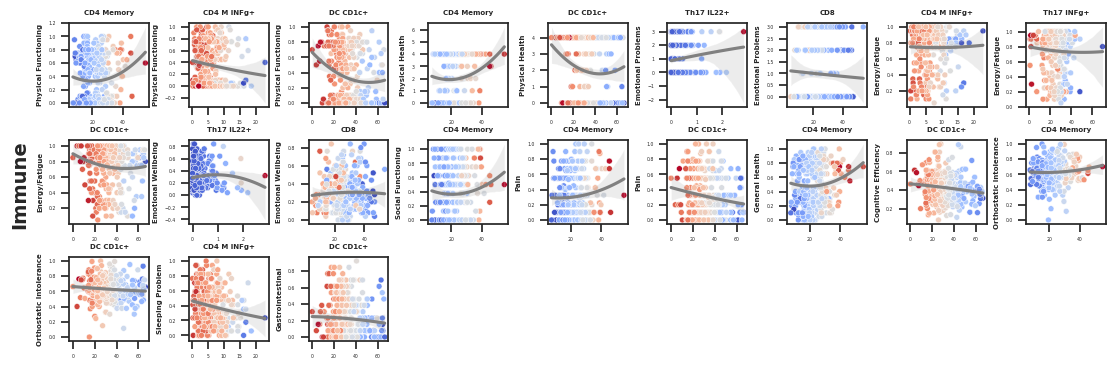

In [14]:
scatter_omics('immune', rownum = 3, colnum = 9)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

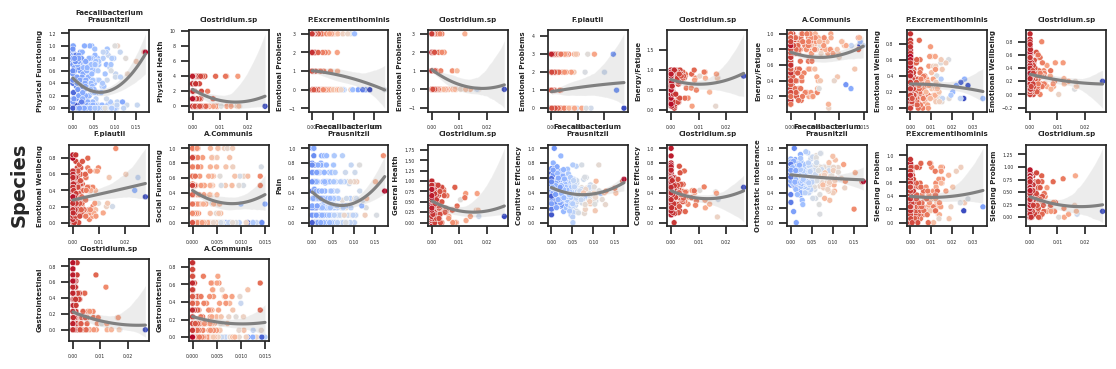

In [15]:
scatter_omics('specie', rownum =3, colnum = 9)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

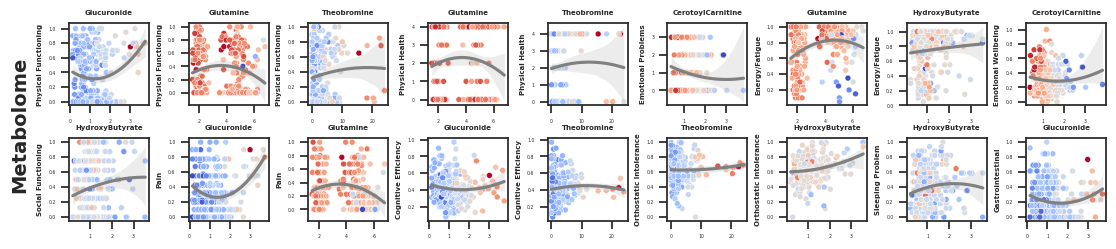

In [16]:
scatter_omics('metabolome', rownum = 2, colnum = 9)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

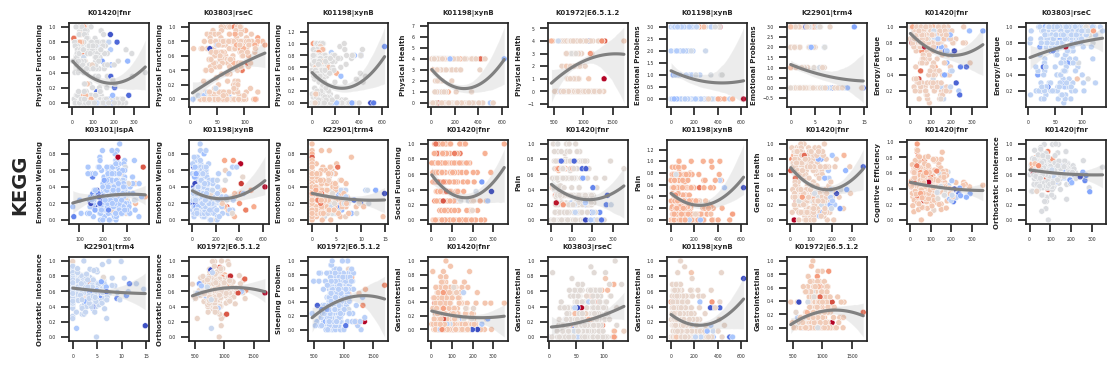

In [17]:
scatter_omics('kegg', rownum = 3, colnum = 9)

---
# Save the biomarkers for supplimental tables

In [18]:
score_biomarkers = pd.DataFrame(index=result_dict.keys(), 
                                columns=[i.columns[0] for i in result_dict['specie']],
                               dtype=object)
for key_i in score_biomarkers.index:
    score_biomarkers.loc[key_i,:]=[i.columns[1:].tolist() for i in result_dict[key_i]]
    score_biomarkers.loc[key_i,:]=score_biomarkers.loc[key_i,:].apply(lambda x: ', '.join(x))
score_biomarkers.index = [model_name_dict[i] for i in score_biomarkers.index]
score_biomarkers.columns = score_name_list
score_biomarkers.to_csv("%s/output/AI_figure/Biomarker_Score_Specific.csv"%(root))

---
# Now plot Biomarker examples for Pain

In [19]:
import matplotlib.gridspec as gridspec

In [20]:
def find_outlier_bounds(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [21]:
def scatter_score_feature_shap(table, ax, feature_name=None, score_name=None, 
                               col_palette='coolwarm', order=2, plot_counts=0):
    sns.scatterplot(data=table, y='score', x='feature', size=0.2, hue='color', palette=col_palette, ax=ax)
    sns.regplot(data=table, y='score', x='feature', scatter=False, color='grey', order=order, ax=ax)
    if plot_counts==0 or plot_counts==3:
        ax.set_ylabel('Pain', fontsize=13, fontweight='bold')
    else:
        ax.set_ylabel(None)
        ax.set_yticks([])
    
    ax.set_xlabel(None)
    ax.legend().remove()
    return ax

In [22]:
def density_plot(data, ax, rotation=None):
    if rotation:
        sns.histplot(data, kde=True, bins=10, color='#53778f', ax=ax, y = data)
        ax.set_xlim(0,65)
        ax.set_ylim(-0.03,1)
    else: 
        sns.histplot(data, kde=True, bins=10, color='#53778f', ax=ax)
    ax.axis('off')

In [23]:
def scatter_pain(score_index = 6, row_heights = [0.2, 1, 0.6, 0.2, 1], col_widths = [1, 0.2, 1, 0.2, 1, 0.4]):
    sns.set(style='ticks', font_scale=0.7, font='sans-serif')
    fig = plt.figure(figsize=(6.5, 4))
    spec = gridspec.GridSpec(5, 6, width_ratios=col_widths, height_ratios=row_heights)
    plot_counts = 0
    for model_name in ['specie','immune','kegg','metabolome']:
        result = result_dict[model_name]
        data = data_dict[model_name].loc[result[0].index,:]
        feature_list = imp_feature_list[model_name]
        feature_name_list = imp_feature_name_list[model_name]
        result_i = result[score_index]
        score_name = score_name_list[score_index]
        for i, feature_i in enumerate(feature_list):
            if feature_i in result_i.columns and feature_i !='K01198':
                table = pd.concat([data.loc[:, feature_i], 
                               result_i.iloc[:,0],
                               result_i.loc[:,feature_i]], axis=1)
                table.columns = ['feature', 'score', 'color']
                if model_name=='kegg':
                    feature_lower, feature_upper = find_outlier_bounds(table, 'feature')
                    score_lower, score_upper = find_outlier_bounds(table, 'score')
                    filtered_table = table[(table['feature'].between(feature_lower, feature_upper)) & 
                              (table['score'].between(score_lower, score_upper))]
                    table = filtered_table
            
                if plot_counts < 3:
                    ax1, ax2 = fig.add_subplot(spec[0,2*plot_counts]), fig.add_subplot(spec[1,2*plot_counts])
                else:
                    ax1, ax2 = fig.add_subplot(spec[3, 2*(plot_counts-3)]), fig.add_subplot(spec[4, 2*(plot_counts-3)])
                density_plot(table.loc[:,'feature'], ax=ax1)
                title = "%s: %s"%(model_name_dict[model_name], feature_name_list[i])
                ax1.set_title(title,fontsize=9, fontweight='bold')
                scatter_score_feature_shap(table, ax2, feature_name_list[i], score_name, plot_counts=plot_counts)
                plot_counts +=1
    
    ax = fig.add_subplot(spec[1, 5])
    density_plot(table.loc[:,'score'], ax=ax, rotation=90)
    ax = fig.add_subplot(spec[4, 5])
    density_plot(table.loc[:,'score'], ax=ax, rotation=90)
  
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig("%s/output/AI_figure/Pain_Features.pdf"%(root),
               bbox_inches='tight',dpi=1000, transparent=True)
    return plt

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

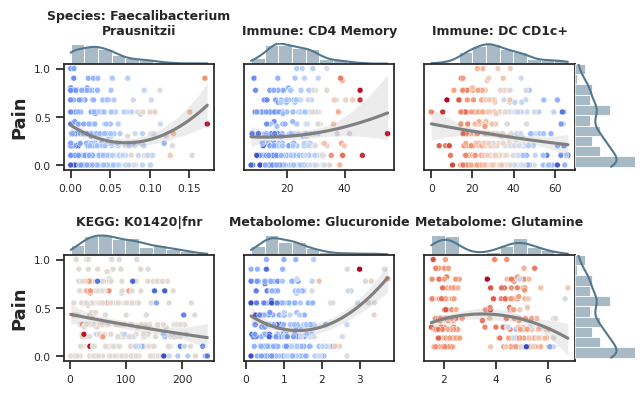

In [24]:
scatter_pain()

---
# Plot Immune-Pain Circlized Zoom in

In [25]:
from matplotlib.gridspec import GridSpec

In [26]:
def plot_zoom_in_circlize(omics_name='immune', score_index=6):
    index = score_index
    score_name = score_name_list[score_index]
    result_list = result_dict[omics_name]
    imp_feature_list_i = imp_feature_list[omics_name]
    imp_feature_name_list_i = imp_feature_name_list[omics_name]
    
    metadata = pd.read_csv("%s/codes/AI/input/metadata.csv"%(root), index_col=0)
    mapping_dict = {'Control': 0, 'MECFS': 1, '<50': 0, '>50': 1, 'Male': 0, 'Female': 1}
    metadata.replace(mapping_dict, inplace=True)

    stack_bar_list = [pd.concat([i.loc[:, 'feature_common_sum'], i.iloc[:, 5:]], axis=1).dropna(axis=0) for i in result_list]
    stack_bar_data = stack_bar_list[index]

    heatmap_list = [i.loc[:, ['feature_rest_sum', 'feature_long_tail_sum', 'feature_common_sum']].iloc[:, :].dropna(axis=0) for i in result_list]
    heatmap_list = [i.abs().transpose() / i.abs().transpose().sum(axis=0) for i in heatmap_list]
    heatmap_data = heatmap_list[index]

    line_plot_list = [i.iloc[:, :2].dropna(axis=0) for i in result_list]
    line_data = line_plot_list[index].to_numpy()
    
    height_ratio_by_feature = [0.05 if feature_i in stack_bar_data.columns else 0.01 for feature_i in imp_feature_list_i]

    sns.set(style='ticks', font_scale=0.5, font='sans-serif')
    fig, axs = plt.subplots(len(height_ratio_by_feature)+4, 1, figsize=(4.9, 3.2), gridspec_kw={'height_ratios': [0.08, 0.22, 0.08, 0.12]+height_ratio_by_feature, 'hspace': 0})

    # Heatmap
    axes = axs[0]
    sns.heatmap(heatmap_data, cmap='BuGn', ax=axes, cbar=False)
    axes.set_yticklabels(['Shared Disease Biomarker Explained Variance', 
                          'Symptom-Specific Biomarker Explained Variance', 
                          'Residual Varience'], fontsize=7)
    axes.set_xticks([])
    [i.set_visible(True) for i in axes.spines.values()]

    # Stacked Bar Chart
    axes = axs[1]
    stack_bar_data = stack_bar_data.to_numpy()
    num_groups = stack_bar_data.shape[0]
    num_categories = stack_bar_data.shape[1]
    color_list = ['grey'] + ['#A74AC7'] * (num_categories - 1)
    x = np.linspace(0, 1, num_groups)

    negative_sums = np.sum(np.where(stack_bar_data < 0, stack_bar_data, 0), axis=1)
    positive_sums = np.sum(np.where(stack_bar_data > 0, stack_bar_data, 0), axis=1)
    ylim = np.max([np.abs(np.min(negative_sums)), np.max(positive_sums)])

    for i in range(num_categories):
        bottoms = [sum(stack_bar_data[g][:i][stack_bar_data[g][:i] > 0]) if stack_bar_data[g][i] > 0 else sum(stack_bar_data[g][:i][stack_bar_data[g][:i] < 0]) for g in range(num_groups)]
        values = stack_bar_data[:, i]
        axes.bar(x, values, color=color_list[i], width=1 / num_groups, linewidth=0, bottom=bottoms)

    axes.set_ylim(-ylim, ylim)
    axes.set_xlim(0, 1)
    axes.set_ylabel('Aggregated SHAP Value\nFeature Contribution', fontsize=9,rotation=0, ha='right', va='center')
    axes.set_xticks([])
    axes.yaxis.tick_right()
    stack_bar_data = stack_bar_list[index]

    # Metadata Heatmap
    axes = axs[2]
    heatmap_meta = metadata.loc[stack_bar_data.index, ['study_ptorhc', 'age_group', 'gender']]
    sns.heatmap(heatmap_meta.to_numpy().T, cmap='binary', ax=axes, cbar=False)
    axes.set_xticks([])
    [i.set_visible(True) for i in axes.spines.values()]
    axes.set_yticklabels(['Control; Patient', 'Age <50; >50', 'Male; Female'], fontsize=7, rotation=0)

    # Line Plot
    axes = axs[3]
    sns.scatterplot(x=x, y=line_data[:, 0], color="#EEA47F", s=6, linewidth=0, ax=axes)
    sns.scatterplot(x=x, y=line_data[:, 1], color="#00539C", s=6, linewidth=0, ax=axes)
    axes.set_ylim(np.min(line_data) - 0.05, np.max(line_data) + 0.1)
    axes.set_xlim(0, 1)
    axes.set_xticks([])
    axes.set_ylabel('True Score vs\nPred Score', fontsize=8,rotation=0, ha='right', va='center')
    axes.yaxis.tick_right()

    # Individual Feature Plots
    color_list = sns.color_palette('tab10', len(imp_feature_list_i)).as_hex()
    for i in range(len(imp_feature_list_i)):
        axes = axs[i + 4]
        axes.set_xlim(0, 1)
        axes.set_xticks([])
        axes.set_yticks([])
        [i.set_visible(False) for i in axes.spines.values()]
        feature_i = imp_feature_list_i[i]
        if feature_i in stack_bar_data.columns:
            y = stack_bar_data[feature_i]
            axes.fill_between(x, y, color=color_list[i], lw=0.5)
            axes.set_ylim(np.min(y), np.max(y))
            axes.set_ylabel(imp_feature_name_list_i[i], fontsize=6, rotation=0, ha='right', va='center')  
            sns.lineplot(x=x, y=0, linewidth=0.5, color='#3b3b3b', ax = axes)
            axes.set_yticks([0])
            axes.yaxis.tick_right()
    axes.set_xlabel("Samples", va='top', fontsize=8)
    
    # Title Text
    fig.text(0.56, 1, "%s - %s"%(model_name_dict[omics_name],score_name), 
             va='center', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("%s/output/AI_figure/Zoomin-%s-%s.pdf"%(root,model_name_dict[omics_name],score_name), 
               dpi=1000, bbox_inches='tight',transparent=True)
    return plt

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

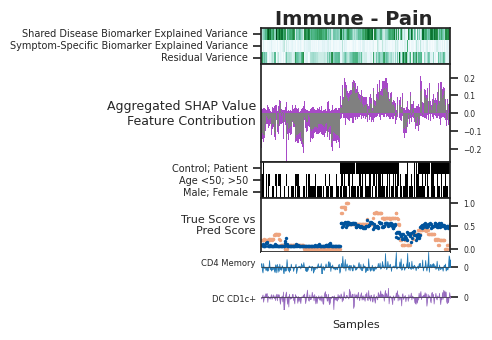

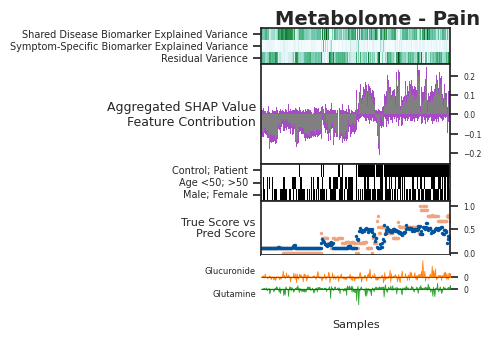

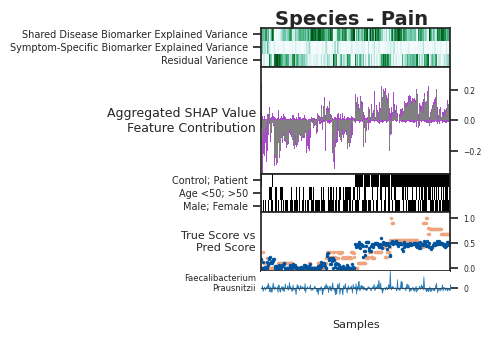

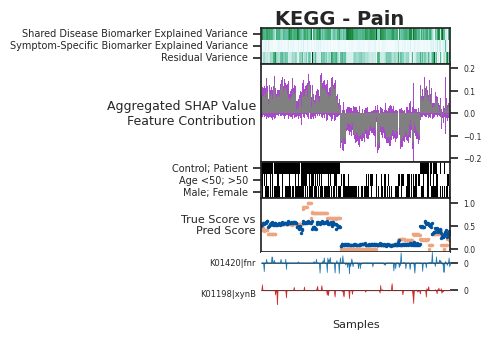

In [27]:
plot_zoom_in_circlize('immune')
plot_zoom_in_circlize('metabolome')
plot_zoom_in_circlize('specie')
plot_zoom_in_circlize('kegg')

---
# Plot Some WaterFall Examples

In [28]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [31]:
def plot_paired_waterfall(model_name, score_index, patient_index, control_index):
    shap_result = load("%s/codes/AI/output/shap/%s_score_%s.pkl"%(root,model_name, score_index))
    metadata = pd.read_csv("%s/codes/AI/input/metadata.csv"%(root), index_col=0)
    data = pd.read_csv("%s/codes/AI/output/cross_validation/full_model/input/%s.csv"%(root, model_name),
                       index_col=0)
    sample_names = data.columns.to_list()
    patient_title = "%s, %s"%(metadata.loc[sample_names[patient_index],'sample_id_tp1'],
                         metadata.loc[sample_names[patient_index],'study_ptorhc'])
    control_title = "%s, %s"%(metadata.loc[sample_names[control_index],'sample_id_tp1'],
                         metadata.loc[sample_names[control_index],'study_ptorhc'])

    sns.set(style='ticks', font_scale=1, font='sans-serif')
    fig, axs = plt.subplots(2, 1, figsize=(2, 1))

    plt.sca(axs[0])
    shap.plots.waterfall(shap_result[patient_index], max_display=10, show=False)
    axs[0].set_title(patient_title,fontsize=14, fontweight='bold')

    plt.sca(axs[1])
    shap.plots.waterfall(shap_result[control_index],  max_display=10, show=False)
    axs[1].set_title(control_title,fontsize=14, fontweight='bold')

    plt.tight_layout()
    fig.text(0,0.5,"%s | %s"%(model_name_dict[model_name],score_name_list[score_index]), rotation=90)
    plt.savefig("%s/output/AI_figure/Waterfall_%s_%s.pdf"%(root,model_name_dict[model_name],
                                                           score_name_list[score_index]), 
            dpi=1000, bbox_inches='tight',transparent=True)
    return plt


## Immune-Pain

In [32]:
model_name = 'immune'
score_index = 6
shap_result = load("%s/codes/AI/output/shap/%s_score_%s.pkl"%(root,model_name, score_index))
metadata = pd.read_csv("%s/codes/AI/input/metadata.csv"%(root), index_col=0)
patient_index = np.where(shap_result.values[:,shap_result.feature_names.index("% CD4+ RO+ CCR6- d6")] == shap_result.values[:,shap_result.feature_names.index("% CD4+ RO+ CCR6- d6")].max())[0][0]
control_index = np.where(shap_result.values[:,shap_result.feature_names.index("% Dcs CD1c+ d0")] == shap_result.values[:,shap_result.feature_names.index("% Dcs CD1c+ d0")].min())[0][0]
plot_paired_waterfall(model_name, score_index, patient_index, control_index)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

## Specie - Gastrointestinal

In [33]:
model_name = 'specie'
score_index = 11
shap_result = load("../output/shap/%s_score_%s.pkl"%(model_name, score_index))
patient_index = np.where(shap_result.values[:,shap_result.feature_names.index("Dysosmobacter_welbionis")] == shap_result.values[:,shap_result.feature_names.index("Dysosmobacter_welbionis")].max())[0][0]
control_index = np.where(shap_result.values[:,shap_result.feature_names.index("Alistipes_communis")] == shap_result.values[:,shap_result.feature_names.index("Alistipes_communis")].min())[0][0]
plot_paired_waterfall(model_name, score_index, patient_index, control_index)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

## Specie - Sleeping

In [34]:
model_name = 'specie'
score_index = 10
shap_result = load("../output/shap/%s_score_%s.pkl"%(model_name, score_index))
patient_index = np.where(shap_result.values[:,shap_result.feature_names.index("Dysosmobacter_welbionis")] == shap_result.values[:,shap_result.feature_names.index("Dysosmobacter_welbionis")].max())[0][0]
control_index = np.where(shap_result.values[:,shap_result.feature_names.index("Clostridium_sp_AM49_4BH")] == shap_result.values[:,shap_result.feature_names.index("Clostridium_sp_AM49_4BH")].min())[0][0]
plot_paired_waterfall(model_name, score_index, patient_index, control_index)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>

## Specie - Pain

In [35]:
model_name = 'specie'
score_index = 6
shap_result = load("../output/shap/%s_score_%s.pkl"%(model_name, score_index))
patient_index = 89
control_index = np.where(shap_result.values[:,shap_result.feature_names.index("Faecalibacterium_prausnitzii")] == shap_result.values[:,shap_result.feature_names.index("Faecalibacterium_prausnitzii")].min())[0][0]
plot_paired_waterfall(model_name, score_index, patient_index, control_index)

<module 'matplotlib.pyplot' from '/projects/ohlab/ruoyun/data/database/conda/envs/py3_R/lib/python3.9/site-packages/matplotlib/pyplot.py'>